# motive: create document vectors using glove vectors and apply kmeans elbow method

In [25]:
import pandas as pd 
import numpy as np 
from  sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt 
import seaborn as sns
import re
plt.style.use("fivethirtyeight")

In [2]:
def loadGloveModel(File):
    print("Loading Glove Model")
    f = open(File,'r', encoding='utf-8')
    gloveModel = {}
    for line in f:
        splitLines = line.split()
        word = splitLines[0]
        wordEmbedding = np.array([float(value) for value in splitLines[1:]])
        gloveModel[word] = wordEmbedding
    print(len(gloveModel)," words loaded!")
    return gloveModel

In [3]:
glove_vectors = loadGloveModel("../data/GloVe/vectors.txt")
glove_vectors["covid19"]

Loading Glove Model
28704  words loaded!


array([ 0.39456 , -0.402685, -0.484987, -0.735917,  2.142848, -1.094912,
        1.121425,  0.741852,  0.355968, -0.394099,  0.342987,  0.598717,
       -1.080016, -1.038038, -0.710382,  0.966173, -0.554905, -0.120793,
        1.035304, -0.524753, -0.646999,  0.764189, -0.37255 ,  0.134055,
       -1.759473,  0.205418,  0.132801, -0.604197, -0.222995,  1.043059,
        0.294879, -0.549645, -0.274023, -0.504667, -0.138191,  0.976385,
       -0.509519,  0.839242, -0.853391, -0.169954,  0.124499, -0.340437,
        0.808791,  0.379731, -0.421217, -0.05845 ,  0.32843 , -0.098347,
        0.871915,  0.396767])

In [4]:
data = pd.read_csv("../data/bbc_toi_yahoo_stats_feats.csv")
data = data.loc[:, ["heading", "content"]]
data

,heading,content
0,domestic abuse: swansea man jailed for murderi...,a man has been jailed for life for battering h...
1,covid-19: how india failed to prevent a deadly...,"in early march, india's health minister harsh ..."
2,"northampton blaze 'cruel blow', say firm's owners",two friends who spent 10 years building up the...
3,einstein handwritten letter with equation fetc...,a letter written by albert einstein containing...
4,florida high school alters 80 'immodest' yearb...,a florida high school is facing a backlash for...
...,...,...
7895,"after long wait, max group sells 13% stake in ...",new delhi/mumbai: diversified max group has so...
7896,high court allows china's bytedance to operate...,mumbai: the bombay high court on tuesday permi...
7897,ajay tyagi: separation of cmd roles not aimed ...,new delhi: capital markets regulator sebi chie...
7898,"linkedin job titles: now, you can call yourse...",bengaluru: linkedin has introduced new job tit...


## create document vectors form GloVe

In [5]:
headings_cleaned = []
for heading in data.loc[:, "heading"]:
    heading_cleaned = []
    tokens = [re.sub("""[!,*)@#+=~`%(&‘_\-:?.👏🏼“^”"'’\]\[]""",'', word.strip()) for word in heading.split(" ")]
    for token in tokens:
        if token in glove_vectors.keys():
            heading_cleaned.append(glove_vectors[token])
    headings_cleaned.append(np.mean(np.array(heading_cleaned), axis=0))

np.array(headings_cleaned).shape

(7900, 50)

In [7]:
contents_cleaned = []
for content in data.loc[:, "content"]:
    content_cleaned = []
    tokens = [re.sub("""[!,*)@#+=~`%(&‘_\-:?.👏🏼“^”"'’\]\[]""",'', word.strip()) for word in content.split(" ")]
    for token in tokens:
        if token in glove_vectors.keys():
            content_cleaned.append(glove_vectors[token])
    contents_cleaned.append(np.mean(np.array(heading_cleaned), axis=0))

np.array(contents_cleaned).shape

(7900, 50)

In [8]:
heading_vectors = pd.DataFrame(
    data=np.array(headings_cleaned), 
    columns=[f"heading_{i}" for i in range(50)],
)
content_vectors = pd.DataFrame(
    data=np.array(contents_cleaned), 
    columns=[f"content_{i}" for i in range(50)],
)

len(content_vectors)

7900

In [9]:
vector_data = pd.concat(objs=[heading_vectors, content_vectors], axis=1)
vector_data.shape

(7900, 100)

In [17]:
train_data = vector_data
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 11)
for k in tqdm(K):
    # Building and fitting the model
    kmeanModel = KMeans(
        n_clusters=k,
        init='k-means++',
        n_init=10,
        max_iter=300,
        tol=0.0001,
        precompute_distances='deprecated',
        verbose=0,
        random_state=None,
        copy_x=True,
        n_jobs='deprecated',
        algorithm='auto'
    )
    kmeanModel.fit(train_data)

    distortions.append(sum(np.min(cdist(train_data, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / train_data.shape[0])
    inertias.append(kmeanModel.inertia_)

    mapping1[k] = sum(np.min(cdist(train_data, kmeanModel.cluster_centers_,
                                    'euclidean'), axis=1)) / train_data.shape[0]
    mapping2[k] = kmeanModel.inertia_

100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


<AxesSubplot:>

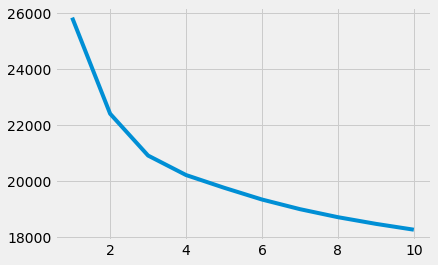

In [18]:
sns.lineplot(x=mapping2.keys(), y=mapping2.values())

In [19]:
kmeanModel = KMeans(
    n_clusters=,
    init='k-means++',
    n_init=10,
    max_iter=300,
    tol=0.0001,
    precompute_distances='deprecated',
    verbose=0,
    random_state=None,
    copy_x=True,
    n_jobs='deprecated',
    algorithm='auto'
)
kmeanModel.fit(train_data)

kmeanModel.labels_

array([1, 6, 4, ..., 7, 9, 8])

In [26]:
data = pd.read_csv("../data/bbc_toi_yahoo_stats_feats.csv")
data.loc[:, "id"] = range(0, len(data))
data.loc[:, "cluster_id"] = kmeanModel.labels_
data

,heading,content,heading_polarity,content_polarity,number_of_words,number_of_sentences,average_word_length,number_of_characters,asl,asw,flesch_ease_test_score,flesch_kincaid_grade_score,id,cluster_id
0,domestic abuse: swansea man jailed for murderi...,a man has been jailed for life for battering h...,0.00,-0.081640,719,28,4.742698,4128,25.678571,1.539638,50.517842,12.592376,0,1
1,covid-19: how india failed to prevent a deadly...,"in early march, india's health minister harsh ...",-0.25,0.035661,1199,63,5.106756,7321,19.031746,1.733945,40.826035,12.292931,1,6
2,"northampton blaze 'cruel blow', say firm's owners",two friends who spent 10 years building up the...,-0.60,-0.199242,306,12,5.032680,1845,25.500000,1.604575,45.205441,13.288987,2,4
3,einstein handwritten letter with equation fetc...,a letter written by albert einstein containing...,0.00,0.165000,236,11,5.254237,1475,21.454545,1.750000,37.008636,13.427273,3,3
4,florida high school alters 80 'immodest' yearb...,a florida high school is facing a backlash for...,0.16,0.043386,665,25,5.001504,3990,26.600000,1.578947,46.257053,13.415579,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7895,"after long wait, max group sells 13% stake in ...",new delhi/mumbai: diversified max group has so...,-0.05,0.115864,892,32,4.794843,5168,27.875000,1.630045,40.640081,14.515779,7895,5
7896,high court allows china's bytedance to operate...,mumbai: the bombay high court on tuesday permi...,0.16,0.059250,384,13,5.054688,2324,29.538462,1.750000,28.803462,16.580000,7896,5
7897,ajay tyagi: separation of cmd roles not aimed ...,new delhi: capital markets regulator sebi chie...,0.00,0.185642,293,11,5.283276,1840,26.636364,1.870307,21.571105,16.867806,7897,7
7898,"linkedin job titles: now, you can call yourse...",bengaluru: linkedin has introduced new job tit...,0.00,0.183394,393,16,5.035623,2371,24.562500,1.727735,35.737650,14.376652,7898,9


In [27]:
data.to_csv("../data/common/bbc_toi_yahoo_news_clustered.csv", index=False)